In [1]:
import sys
sys.path.insert(0, "../../src/")
from framework import *
from algorithms import nelder_mead_multi

In [2]:
nelder_mead_multi.load_best_instance('../../result/june.db')
save_handler = SaveHandlerJSON('../../result/june/')

nm_ins = nelder_mead_multi.best_instance
nm_ins.trial.params

{}

In [3]:
# nm_ins.run(
#     save_handler=save_handler,
#     save_partial=False,
#     restart=True,
#     does_prune=False,
# )
nm_ins.load_results(save_handler=save_handler, partial=False)

{'success_rate': 0.25,
 'failure_rate': 0.75,
 'success_cnt': 6,
 'avg_success_eval': 22821.166666666668,
 'hv': 6794.708333333333,
 'par2': 80705.29166666667,
 'par10': 380705.2916666667,
 'avg_height': 1320.3137966615043,
 'ert': 172821.16666666666,
 'sp': 91284.66666666667,
 'success_rate_upper': 0.44899825312106434,
 'success_rate_lower': 0.11999203479342332,
 'success_rate_length': 0.32900621832764104,
 'gary_ert': 8295.416}

In [4]:
res = nm_ins.results[2]
len(res.end_of_iterations)

706

In [5]:
print(res.end_of_iterations[:20])

[134, 208, 272, 338, 411, 496, 577, 648, 712, 776, 829, 913, 993, 1057, 1125, 1190, 1266, 1343, 1409, 1477]


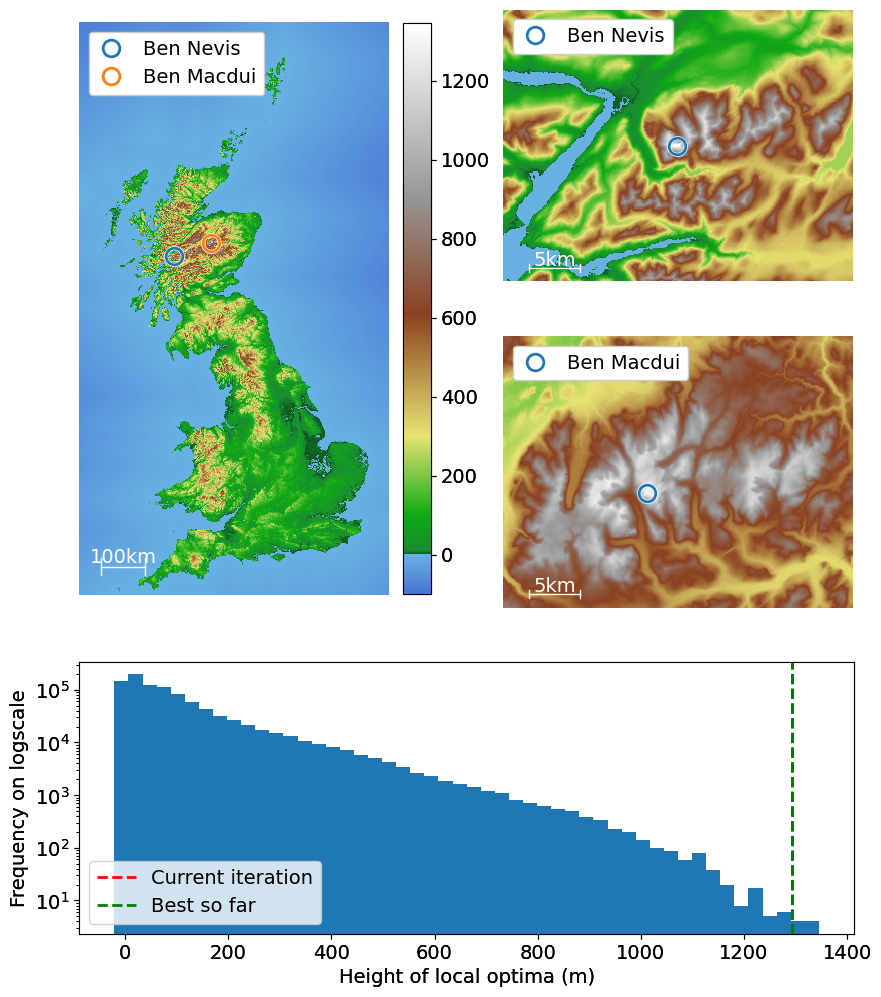

In [7]:
import numpy as np
maxima_heights = np.load('../../basin-problem/res/maxima_heights.npy')

from framework import ResultAnimation

# we only render the first 20 frames for demonstration;
# for the full video, change frame_num to None
result_animation = ResultAnimation(res, maxima_heights, frame_num=1477, mode='evaluations')
result_animation.save(file_name='eva3.mp4', fps=5)

In [ ]:
import nevis
ben_x, ben_y = nevis.ben().grid
ben_x, ben_y
f = nevis.linear_interpolant()
f(ben_x, ben_y)
ben_x, ben_y
b = 8e3
nevis.plot(
            
            boundaries=[ben_x - b * 2.125,
                        ben_x + b * 2.125,
                        ben_y - b * 1.65,
                        ben_y + b * 1.65],
            zoom=1/1.5,
            points=np.array([[ben_x, ben_y]])
            
        )

In [ ]:
nm_ins.performance_measures()

In [ ]:
nm_ins.performance_measures()

In [ ]:
nm_ins.performance_to_latex()

In [ ]:
nm_ins.plot_convergence_graph()

In [ ]:
nm_ins.plot_stacked_graph()

In [ ]:
nm_ins.plot_stacked_graph(mode='terminate')

In [ ]:
res = nm_ins.results[4]
res.plot_global()